#### Ejercicio 1: "Re-implementando" (opcional):

Copiar esta notebook y borrar las celdas donde creamos la red neuronal (desde la sección "Creando nuestra red neuronal" en adelante). De modo que sólo quede la parte donde importamos el dataset. Y re-escribir:
- La creación de los pesos y la función que dado las features produce la predicción.
- La función de costo (negative log likehood).
- La métrica: accuracy.
- El loop de entrenamiento, incluyendo código para evaluar en cada época y mostrar cómo mejora la métrica.
- Un ejemplo de cómo se usa el modelo para inferencia (sobre un sólo caso, para calcular la predicción).

In [3]:
import torch
import numpy as np
from matplotlib import pyplot
import math

Matplotlib is building the font cache; this may take a moment.


In [100]:
data=np.load("../data/australFace/AUSTRAL_MCD_FACE_grayscale.npy")
target=np.load("../data/australFace/AUSTRAL_MCD_FACE_TARGET.npy")

In [5]:
data.shape, target.shape

((224, 150, 150), (224,))

In [34]:
#Flatter de la imagen, actualmente esta en forma de matriz, quiero llevarla a un array y normalizarla.
# Supongamos que `data` tiene forma (224, 150, 150)
data_flattened = data.reshape(data.shape[0], -1)/ 255.0  # Nuevo shape será (224, 22500) + normalizacion
print(data_flattened.shape)  # Salida: (224, 22500)


(224, 22500)


In [55]:
names_np = np.array(['Marcelo T', 'Carlos G', 'Ana L', 'Marcelo T', 'Ana L'])
print(type(names_np))
print(type(target))


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [66]:
# Arreglo de nombres
names_np = target #np.array(['Marcelo T', 'Carlos G', 'Ana L', 'Marcelo T', 'Ana L'])

# Crear diccionario único para codificación
unique_names = np.unique(names_np)
name_to_index = {name: i for i, name in enumerate(unique_names)}

# Aplicar codificación
target_encoded = np.array([name_to_index[name] for name in names_np])

print("Diccionario de codificación:", name_to_index)
print("Codificación:", target_encoded)



Diccionario de codificación: {np.str_('Andres'): 0, np.str_('Carla'): 1, np.str_('Claudia'): 2, np.str_('Edu'): 3, np.str_('Elemir'): 4, np.str_('Fernanda'): 5, np.str_('Geronimo'): 6, np.str_('Hernan'): 7, np.str_('Jiang'): 8, np.str_('Joaquin'): 9, np.str_('Josefina'): 10, np.str_('Julieta'): 11, np.str_('Lujan'): 12, np.str_('Mai'): 13, np.str_('Marcelo G'): 14, np.str_('Marcelo G '): 15, np.str_('Marcelo T'): 16, np.str_('Maribel'): 17, np.str_('Marisa'): 18, np.str_('Nestor'): 19, np.str_('Oscar'): 20, np.str_('Ramon'): 21, np.str_('Rodrigo G'): 22, np.str_('Sebastian'): 23, np.str_('Silvia'): 24}
Codificación: [16  0  6 16 19  1 23 20  9 12 20 23  1  8 10  7  0 10 16  1  4  8 14 22
 13 10 20  6  8  1  6 20 13 13  5  7 11 24 10 19 13 15  7  5  0 16 17 18
 13  5  3 23  0 10 20 13 11 23 17 18  1 17  0 10  4 11 23 12  1 13  7 14
  7  8 13 22 21  0  5 21 16  3 21  5 22 23 16 16  8  1  5  4 13 22  6  6
 16  9 19 12 18  0 24 24 16  7 13  2 22  5 17  7 12  1 18  7 23 17  5  6
 19 10 13  

In [35]:
data_flattened[0]

array([0.32153647, 0.35682706, 0.36466941, ..., 0.40780235, 0.43525059,
       0.40780235], shape=(22500,))

In [6]:
print(f'Cantidad de caras distintas {len(np.unique(target))}')

Cantidad de caras distintas 25


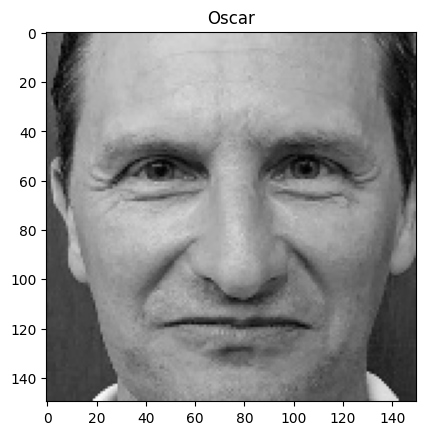

In [101]:
#data_grayscale
pyplot.imshow(data[10], cmap="gray")
pyplot.title(target[10])
pyplot.show()

## Creando nuestra red neuronal

Vimos que una red neuronal es una composición de funciones que llevan de $\large \mathbb{R}^{n_{in}}$ a $\large \mathbb{R}^{n_{out}}$, como composición de funciones que transforman vectores en vectores:

$\Large \mathbb{R}^{n_{in}} \rightarrow \mathbb{R}^{n_{hidden_1}} \rightarrow \mathbb{R}^{n_{hidden_2}} \rightarrow ... \rightarrow \mathbb{R}^{n_{out}}$

Vamos a entrenar una red de dos capas ocultas de tamaño 512. O sea concretamente nuestra red tendrá la forma:

$\Large \mathbb{R}^{22500} \rightarrow \mathbb{R}^{512} \rightarrow \mathbb{R}^{512} \rightarrow \mathbb{R}^{25}$

Como vimos cada función toma los valores de la capa anterior $h_{t}$ y produce los de la capa subsiguiente $h_{t+1}$ aplicando una transformación lineal seguida de una función no-lineal $g$:

$h_{t+1} = g( h_t \times W_t + b_t )$

$g$ será la función $ReLU$ excepto para la última capa que utilizaremos la función softmax:

$ReLU(x) = max(0, x)$

La función softmax toma un vector de longitud $n$, lo positiviza aplicando $e^x$ y luego divide cada componente por la suma de cada uno de dichos términos positivos. Como resultado da un vector de longitud $n$ que es siempre positivo y la suma es $1$. Se utiliza cuando se espera que la salida sea una distribución de probabilidad. En problemas de clasificación, la salida son $n$ probabilidades siendo $n$ el número de clases (la probabilidad que da el modelo para que el $x$ suministrado pertenezca a cada una de las clases).

Los pesos de cada capa son inicializados de manera aleatoria con una fórmula que los escala teniendo en cuenta la dimensión de entrada y salida. Lo que se pretende con esto es que los valores de las activaciones no crezcan demasiado, ya que de hacerlo luego $e^x$ (aplicado en la última capa por la softmax resultará en el valor inf.

In [36]:
def w_rand(n_in, n_out):
    return torch.normal(0, math.sqrt(6) / math.sqrt(n_in + n_out), size=(n_in,n_out), requires_grad=True)

W_1 = w_rand(150*150, 512)
b_1 = torch.zeros(512, requires_grad=True)

W_2 = w_rand(512, 512)
b_2 = torch.zeros(512, requires_grad=True)

W_3 = w_rand(512,25)
b_3 = torch.zeros(25, requires_grad=True)

weights = [W_1, b_1, W_2, b_2, W_3, b_3]

def softmax(x):
    return x.exp() / x.exp().sum(-1).unsqueeze(-1)

def calculate_predictions(t):
    linear_combination_1 = t @ W_1 + b_1
    hidden_layer_1 = torch.max(torch.tensor(0), linear_combination_1)
    
    linear_combination_2 = hidden_layer_1 @ W_2 + b_2
    hidden_layer_2 = torch.max(torch.tensor(0), linear_combination_2)

    linear_combination_3 = hidden_layer_2 @ W_3 + b_3
    
    return softmax(linear_combination_3)

pred = calculate_predictions(torch.tensor(data_flattened[0].flatten()))
pred, pred.shape

(tensor([3.1906e-03, 6.8906e-03, 5.2110e-04, 1.8366e-02, 1.3490e-02, 4.6969e-04,
         8.6246e-03, 3.0162e-04, 3.4412e-03, 1.2695e-02, 2.2243e-04, 2.6031e-03,
         1.2443e-02, 6.3879e-04, 9.5331e-02, 1.0533e-03, 1.5522e-03, 6.1845e-02,
         6.1856e-01, 7.1492e-04, 1.1537e-02, 4.5284e-02, 8.4371e-03, 7.0212e-02,
         1.5791e-03], grad_fn=<DivBackward0>),
 torch.Size([25]))

In [37]:
# Encontrar el índice del valor máximo
max_index = torch.argmax(pred)

print("El índice del valor máximo es:", max_index.item())
print("El valor máximo es:", pred[max_index].item())

El índice del valor máximo es: 18
El valor máximo es: 0.6185553073883057


In [38]:
pred.sum()

tensor(1.0000, grad_fn=<SumBackward0>)

In [67]:
batch_size = 32

def get_batch(a, i):
    return torch.tensor(a[batch_size*i:batch_size*(i+1),...], dtype=torch.float32)

x_batch = get_batch(data_flattened, 0)
y_batch = get_batch(target_encoded, 0)

x_batch.shape, y_batch.shape

(torch.Size([32, 22500]), torch.Size([32]))

In [69]:
batch_pred = calculate_predictions(x_batch.flatten(start_dim=1))
batch_pred.shape

torch.Size([32, 25])

In [70]:
y_batch.shape

torch.Size([32])

In [71]:
def negative_log_likehood(pred_batch, target_batch):
    bz = pred_batch.shape[0]
    target_batch = target_batch.long()
    return -torch.log(pred_batch[range(bz), target_batch]).mean()

negative_log_likehood(batch_pred, y_batch)

tensor(5.5853, grad_fn=<NegBackward0>)

In [72]:
def accuracy(probs, target):
    class_predictions = torch.argmax(probs, dim=1)
    return (class_predictions == target).float().mean()

accuracy(batch_pred, y_batch)

tensor(0.)

In [78]:
n_batches_train.shape

(22500,)

In [ ]:
data_flattened
target_encoded

In [95]:
import torch
from torch.utils.data import TensorDataset, random_split

# Supongamos que data y target ya están en formato de tensores
data = torch.tensor(data_flattened, dtype=torch.float32)
target = torch.tensor(target_encoded, dtype=torch.long)

# Crear un conjunto de datos combinado
dataset = TensorDataset(data, target)

# Definir tamaños para train y valid
train_size = int(0.8 * len(dataset))  # 80% para entrenamiento
valid_size = len(dataset) - train_size  # 20% para validación

# Dividir los datos
train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])

# Ahora puedes crear DataLoaders si es necesario
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

print(f"Tamaño de train: {len(train_dataset)}")
print(f"Tamaño de valid: {len(valid_dataset)}")


Tamaño de train: 179
Tamaño de valid: 45


In [90]:
x_train, y_train = train_dataset[0]
x_train

In [94]:
len(train_loader)//batch_size

0

In [97]:
# n_samples_train = x_train.shape[0]
# n_samples_valid = x_valid.shape[0]

# n_batches_train = n_samples_train // batch_size
# n_batches_valid = (n_samples_valid + batch_size - 1) // batch_size

n_batches_train = len(train_dataset) // batch_size
n_batches_valid = (len(valid_dataset) + batch_size - 1) // batch_size

learning_rate = 0.001
n_epochs = 15

for idx_epoch in range(n_epochs):
    # Loop de entrenamiento
    loss_train_sum = 0
    #for idx_batch in range(n_batches_train):
    for idx_batch, (x_train_batch, y_train_batch) in enumerate(train_loader):
        
        # Obtenemos un mini-batch de entrenamiento
        # x_train_batch, y_train_batch = get_batch(x_train, idx_batch), get_batch(y_train, idx_batch)
        # x_train_batch = data_batch
        # y_train_batch = target_batch
        
        # Calculamos las predciones del modelo para dicho mini-batch
        predictions = calculate_predictions(x_train_batch)
    
        # Calculamos el costo de dichas predicciones
        loss = negative_log_likehood(predictions, y_train_batch)
    
        # Calculamos el gradiente de los pesos
        # Antes de llamar a backwards, inicializarmos los gradientes en cero. 
        # Recordar que Pytorch acumula los gradientes, de modo que si llamamos 
        # a backwards dos veces sin inicializar en cero, se acumularán ambos cálculos.
        for w in weights:
            if w.grad is not None:
                w.grad.zero_()
        loss.backward()
        loss_train_sum += loss.item()
    
        # Actualizaremos los pesos utilizando los gradientes, según la fórmula de descenso por gradiente
        for w in weights:
            w.data -= w.grad.data * learning_rate
        
    # Una vez terminado el entrenamiento
    # Shuffleamos los datos de entrenamiento de modo que los mini-batches de la próxima epoch sean distintos
    # idxs_rand = torch.randperm(x_train.shape[0]) #no es necesario, ya lo hace DataLoader con shuffle=True
    # # x_train = x_train[idxs_rand,...]
    # # y_train = y_train[idxs_rand,...]
    # x_train = torch.tensor(x_train, dtype=torch.float32).clone()[idxs_rand]
    # y_train = torch.tensor(y_train, dtype=torch.float32).clone()[idxs_rand]

    # Evaluamos los datos en validación
    loss_validation_sum = 0
    accuracy_sum = 0
    #for idx_batch in range(n_batches_valid):
    for idx_batch, (x_valid_batch, y_valid_batch) in enumerate(valid_loader):
        # Obtenemos un mini-batch de validación
        # x_valid_batch, y_valid_batch = get_batch(x_valid, idx_batch), get_batch(y_valid, idx_batch)
        predictions = calculate_predictions(x_valid_batch)
        loss = negative_log_likehood(predictions, y_valid_batch)
        loss_validation_sum += loss.item()

        # Evaluamos nuestra métrica. NUNCA lo hacemos en train
        accuracy_sum += accuracy(predictions, y_valid_batch).item()
    
    # Imprimimos el loss en train y validación y la métrica (siempre en validación)
    accuracy_validation = accuracy_sum / n_batches_valid
    loss_validation = loss_validation_sum / n_batches_valid
    loss_train = loss_train_sum / n_batches_train
    print(f'epoch {idx_epoch} | train loss {loss_train} | validation loss {loss_validation} | accuracy {accuracy_validation}')


epoch 0 | train loss 2.076767420768738 | validation loss 2.441149353981018 | accuracy 0.22475961595773697
epoch 1 | train loss 2.136508011817932 | validation loss 2.4761626720428467 | accuracy 0.2475961595773697
epoch 2 | train loss 2.0021610975265505 | validation loss 2.3382555842399597 | accuracy 0.34735578298568726
epoch 3 | train loss 1.8634207248687744 | validation loss 2.4090200662612915 | accuracy 0.3329326957464218
epoch 4 | train loss 1.8249911308288573 | validation loss 2.3405020236968994 | accuracy 0.3257211595773697
epoch 5 | train loss 1.7306872844696044 | validation loss 2.4982560873031616 | accuracy 0.2632211595773697
epoch 6 | train loss 1.8681307792663575 | validation loss 3.048474907875061 | accuracy 0.18629807978868484
epoch 7 | train loss 2.1648748397827147 | validation loss 2.402094602584839 | accuracy 0.3173076957464218
epoch 8 | train loss 1.7207655906677246 | validation loss 2.5213637351989746 | accuracy 0.22475961595773697
epoch 9 | train loss 1.618259072303772